# **ADSP - P8 PROJECT** - scientific papers classifier based on NLP
---
**CANDIDATES**

GILLIO FRANCESCO

SEMINARIO YRIGOYEN CESAR AUGUSTO

**COURSE** Applied Data Science Project

**University** Politecnico di Torino - Italy


## Project description

**BertTopic** is used to create a semi-supervised model with labels available

**Dataset for testing** can be downloaded fro hugginface at the link: [dhiruHF papers multilabeled](https://huggingface.co/datasets/dhiruHF/research_paper_multi_label_data_balanced)

**Dataset for the project** is contained in the input_data folder, called: articles_2023.csv

 ## <span style="font-family:Verdana; color:blue">  0. TO DO

<span style="font-family:Verdana; color:blue">

- download similar dataset from hugging-face to start - DONE
- data cleaning - DONE
- create embeddings - DONE
- export embeddings - DONE
- start with the model - IN PROGRESS
***

## 1. Exploring the dataset

In [1]:
%%capture
!pip install bertopic
!pip install datasets
!pip install openai
import tqdm as notebook_tqdm
from tqdm.autonotebook import tqdm, trange

import pandas as pd
import numpy as np

### 1.1 Exploring similar dataset




In [ ]:
from datasets import load_dataset

dataset = load_dataset("dhiruHF/research_paper_multi_label_data_balanced")
terms_number= len(dataset['train'])
print(f"N° wiki terms: {terms_number}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/382 [00:00<?, ?B/s]

(…)-00000-of-00001-6cb8c751614cff33.parquet:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1985 [00:00<?, ? examples/s]

N° wiki terms: 1985


In [ ]:
def get_chapters(text):
    chapters = text.split('###')[2]
    labels = text.split('###')[3]
    labels = labels.split(':')[1]
    title=chapters.split('\n')[2].split(':')[1]
    abstract=chapters.split('\n')[3:]
    abstract[0]=abstract[0][9:]
    delimiter="\n"
    abstract=delimiter.join(abstract)
    #labels=labels.split(',')
    #labels=[label.strip() for label in labels]
    item_dict={}
    item_dict['title']=title
    item_dict['abstract']=abstract
    item_dict['labels']=labels
    return item_dict


In [ ]:
item=get_chapters(dataset['train'][0]['text'])
print(item['title'])

 Reconstructing Subject-Specific Effect Maps


In [ ]:
dataset['train'][0]['text'].split('###')[2]

"RESEARCH PAPER:\n\nTitle: Reconstructing Subject-Specific Effect Maps\nAbstract:   Predictive models allow subject-specific inference when analyzing disease\nrelated alterations in neuroimaging data. Given a subject's data, inference can\nbe made at two levels: global, i.e. identifiying condition presence for the\nsubject, and local, i.e. detecting condition effect on each individual\nmeasurement extracted from the subject's data. While global inference is widely\nused, local inference, which can be used to form subject-specific effect maps,\nis rarely used because existing models often yield noisy detections composed of\ndispersed isolated islands. In this article, we propose a reconstruction\nmethod, named RSM, to improve subject-specific detections of predictive\nmodeling approaches and in particular, binary classifiers. RSM specifically\naims to reduce noise due to sampling error associated with using a finite\nsample of examples to train classifiers. The proposed method is a wrap

In [ ]:
#converting in structure dict:{title,abstract,labels}
data_dict=[get_chapters(item) for item in dataset['train']['text']]

In [ ]:
item=1345
print(f"title:\n {data_dict[item]['title']}")
print(f"abstract:\n {data_dict[item]['abstract']}")
print(f"labels:\n {data_dict[item]['labels']}")

title:
  Bounds on the expected size of the maximum agreement subtree for a given tree shape
abstract:
    We show that the expected size of the maximum agreement subtree of two
$n$-leaf trees, uniformly random among all trees with the shape, is
$\Theta(\sqrt{n})$. To derive the lower bound, we prove a global structural
result on a decomposition of rooted binary trees into subgroups of leaves
called blobs. To obtain the upper bound, we generalize a first moment argument
for random tree distributions that are exchangeable and not necessarily
sampling consistent.



labels:
  ['Quantitative Biology']


<Axes: xlabel='labels'>

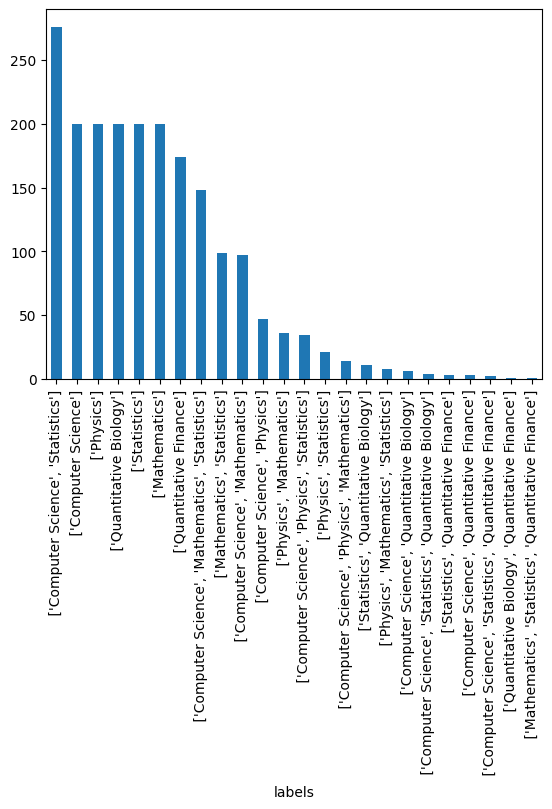

In [ ]:
data_df= pd.DataFrame(data_dict)
data_df['labels'].value_counts().plot(kind='bar')

### 1.2 Exploring article_2023 dataset

In [2]:
!git clone https://github.com/adsp-polito/2024-P8-PPS.git

Cloning into '2024-P8-PPS'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12/12), 1.02 MiB | 3.91 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [3]:
data_df=pd.read_csv('/content/2024-P8-PPS/input_data/articles_2023.csv')
titles=data_df['Title'].to_list()
abstracts=data_df['Abstract'].to_list()
labels=data_df['Label'].to_list()

<Axes: xlabel='Label'>

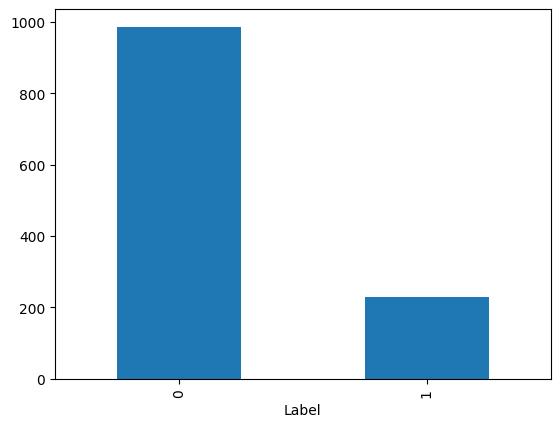

In [4]:
data_df['Label'].value_counts().plot(kind='bar')

In [ ]:
print(abstracts[0])

PURPOSE: The transition towards adult-focused healthcare comprises a complex process requiring careful, individualized guidance of adolescents with congenital heart disease (CHD). Detailed data on their preferences regarding disease-related information and acquirable transitional skills are mostly lacking. We examined the preferences of CHD adolescents in the early transition stage. METHODS: A cross-sectional descriptive study was performed with adolescents recruited from a transition program. Two questionnaires assessing needs for information and transitional skills were used. Only questionnaires completed in the early transition stage were included. RESULTS: Forty-nine adolescents participated (mean age 15.9 ± 1.2 years, 43% girls). 59% requested information about their heart and previous and/or future surgeries/interventions, 45% about sports and medication, and a maximum of 27% about psychosocial topics. More girls than boys requested surgical information (76% versus 46%; p = 0.04)

Text(0.5, 1.0, 'Word Count Distribution')

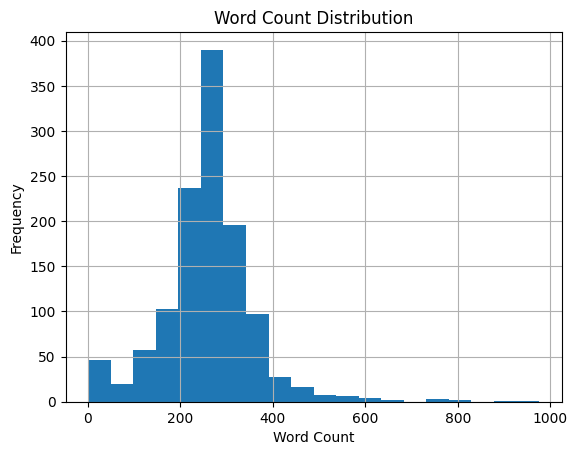

In [5]:
#counting words in each abstract to manage embeddings
#splitting by string:
data_df['Abstract_word_count'] = data_df['Abstract'].apply(lambda x: len(str(x).split()))

ax=data_df['Abstract_word_count'].hist(bins=20)
ax.set_xlabel('Word Count')
ax.set_ylabel('Frequency')
ax.set_title('Word Count Distribution')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Text(0.5, 1.0, 'Word Count Distribution - NLTK')

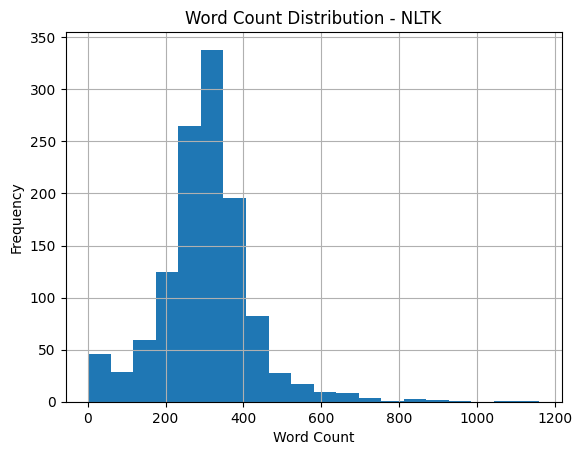

In [8]:
#nltk:
#it holds punctuation, incase we don't want it use
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
nltk.download('punkt')
nltk.download('punkt_tab')
words=[len(word_tokenize(str(text))) for text in data_df['Abstract']]
data_df['Abstract_word_count_nltk']=words

ax=data_df['Abstract_word_count_nltk'].hist(bins=20)
ax.set_xlabel('Word Count')
ax.set_ylabel('Frequency')
ax.set_title('Word Count Distribution - NLTK')

## 2. Preparing the dataset for BERTopic architecture

In [9]:
# functions preparing the dataset for BERTopic architecture

#1. Removing duplicates
print(f"initial size: {data_df.shape}")
data_df_clean=data_df.drop_duplicates(subset=['Title'], keep ='first')
print(f"new size of items after removing duplicates: {data_df_clean.shape}")


initial size: (1215, 19)
new size of items after removing duplicates: (1214, 19)


In [10]:
#2. Managing nan or empty sections
tot_nan=data_df_clean['Title'].isnull().sum()
print(f"total nan Titles in dataset: {tot_nan}")
tot_nan=data_df_clean['Abstract'].isnull().sum()
print(f"total nan abstracts in dataset: {tot_nan}")

#saving titles without abstract --> find abstracts and complete dataset
#titles_nanAbs=data_df_clean[data_df_clean['Abstract'].isnull()]['Title']#.to_list()
#titles_nanAbs.to_excel('titles_nanAbs.xlsx')
#print(f"titles with nan in abstract: {titles_nanAbs}")

#Manage nan _hyp1: if both title and abstract nan -> delete; if just 1 nan, keep item and put an empty string (to allow tokenization)
for elem in data_df_clean.index:
    if pd.isnull(data_df_clean.at[elem, 'Title']) and pd.isnull(data_df_clean.at[elem, 'Abstract']):
        data_df_clean.drop(elem, inplace=True)
    elif pd.isnull(data_df_clean.at[elem, 'Title']):
        data_df_clean.at[elem, 'Title'] = ''
    elif pd.isnull(data_df_clean.at[elem, 'Abstract']):
        data_df_clean.at[elem, 'Abstract'] = ''


tot_nan=data_df_clean['Title'].isnull().sum()
print(f"total nan Titles in dataset after manage: {tot_nan}")
tot_nan=data_df_clean['Abstract'].isnull().sum()
print(f"total nan abstracts in dataset after manage: {tot_nan}")


total nan Titles in dataset: 0
total nan abstracts in dataset: 44
total nan Titles in dataset after manage: 0
total nan abstracts in dataset after manage: 0


## 3. Setting up base BERTopic model

### 3.1 Precalculate embeddings (if loading pass to 3.2)


In [12]:
from sentence_transformers import SentenceTransformer
# Pre-calculate embeddings
embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

In [13]:
title_embeddings = embedding_model.encode(data_df_clean['Title'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

In [14]:
abstract_embeddings = embedding_model.encode(data_df_clean['Abstract'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

In [15]:
# saving data
#import numpy as np
np.save('title_embeddings_all-MiniLM-L6-v2.npy', title_embeddings)
np.save('abstract_embeddings_all-MiniLM-L6-v2.npy', abstract_embeddings)

In [16]:
data_df_clean.to_pickle('data_df_clean.pkl')

### 3.2 Uploading embeddings

In [ ]:
# first load the files to the drive folder following this process
#UNCOMMENT BELOW TO LOAD
'''
!git clone https://github.com/adsp-polito/2024-P8-PPS.git
title_embeddings=np.load('/content/2024-P8-PPS/embeddings/title_embeddings_all-MiniLM-L6-v2.npy')
abstract_embeddings=np.load('/content/2024-P8-PPS/embeddings/abstract_embeddings_all-MiniLM-L6-v2.npy')
data_df=pd.read_pickle('/content/2024-P8-PPS/embeddings/data_df_clean.pkl')
'''

### 3.3 Setting up bertopic blocks

In [ ]:
#!pip install 'umap-learn==0.3.10'
from umap import UMAP
umap_model = UMAP(n_neighbors=20, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

In [ ]:
from hdbscan import HDBSCAN
hdbscan_model = HDBSCAN(min_cluster_size=20, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
#additional_stopwords=['Signs','signs','Sign', 'sign', 'Symptoms','symptoms','Symptom','symptom','include','affected','people','features','patients','disease','present','common','usually'] #'syndrome', disease, patient, patients
stop_words_mod=list(text.ENGLISH_STOP_WORDS)#+additional_stopwords
vectorizer_model = CountVectorizer(stop_words=stop_words_mod, min_df=1, ngram_range=(1, 2))
# vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))

### 3.3 DEFINING representation models

In [ ]:
#!pip install typing-extensions --upgrade

import openai
import bertopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech
#from spacy import parts_of_speech
# KeyBERT
keybert_model = KeyBERTInspired()

# Part-of-Speech
pos_model = PartOfSpeech("en_core_web_sm")
# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)

# GPT-3.5
prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short but highly descriptive topic label of at most 5 words. Make sure it is in the following format:
topic: <topic label>
"""
client = openai.OpenAI(api_key="sk-...")
#openai_model = OpenAI(client, model="gpt-3.5-turbo", exponential_backoff=True, chat=True, prompt=prompt)

# All representation models
representation_model = {
    "KeyBERT": keybert_model,
    # "OpenAI": openai_model,  # Uncomment if you will use OpenAI
    "MMR": mmr_model,
    "POS": pos_model
}

## 4. Model exploration

### Tests:
HDBSCAN - choose reasonable number of topics


Vectorizer tests
- mindf=1 : changes just group 12: war--- to veteran.sle, war, gulf. # of topics are the same. SLe is the most representative doc, it's autoimmune disease


In [ ]:
from bertopic import BERTopic
from sklearn.cluster import KMeans
#put here the block to study in order to understand behaviors
# list_to_check=range(20,160,10)
list_to_check=[(1,3)]

params=[]
# list_to_check=range(140,160,10)
for size in list_to_check:#reversed(list_to_check):
  # hdbscan_model = HDBSCAN(min_cluster_size=size, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
  vectorizer_model = CountVectorizer(stop_words=stop_words_mod, min_df=1, ngram_range=size)
  # hdbscan_model= KMeans(n_clusters=size)
  topic_model = BERTopic(

  # Pipeline models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)
  topics, probs = topic_model.fit_transform(data_df['title'].tolist(), abstract_embeddings)
  print(f"size {size} analyzed")
  a=topic_model.get_topic_freq()
  # a['index_old']=a.index
  b=topic_model.get_topic_info()['Name']
  a.reset_index(inplace=True)
  b.reset_index(drop=True)
  a=pd.concat([a,b],axis=1)
  params.append(a)
  topic_model.get_topic_info()

2024-11-07 21:49:17,156 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-07 21:49:39,592 - BERTopic - Dimensionality - Completed ✓
2024-11-07 21:49:39,797 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-07 21:49:39,884 - BERTopic - Cluster - Completed ✓
2024-11-07 21:49:39,895 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-07 21:49:52,921 - BERTopic - Representation - Completed ✓


size (1, 3) analyzed


In [ ]:
topic_model.get_topic_info()
# params[13].head()

,Topic,Count,Name,Representation,KeyBERT,MMR,POS,Representative_Docs
0,-1,533,-1_learning_based_data_model,"[learning, based, data, model, using, analysis...","[bayesian optimization, machine learning, opti...","[learning, bayesian, models, prediction, stoch...","[data, model, analysis, optimization, networks...",[ Batched High-dimensional Bayesian Optimizati...
1,0,252,0_neural_deep_learning_networks,"[neural, deep, learning, networks, neural netw...","[deep neural networks, deep neural network, de...","[deep neural, adversarial, deep neural network...","[neural, deep, learning, networks, neural netw...",[ On Deep Neural Networks for Detecting Heart ...
2,1,238,1_estimation_sparse_rank_stochastic,"[estimation, sparse, rank, stochastic, method,...","[stochastic variance reduced, convex optimizat...","[sparse, stochastic, regression, kernel, low r...","[estimation, sparse, rank, stochastic, method,...",[ Doubly Accelerated Stochastic Variance Reduc...
3,2,202,2_spaces_algebras_groups_functions,"[spaces, algebras, groups, functions, mathbb, ...","[dimensional manifolds, semigroups, characteri...","[spaces, algebras, groups, generalized, graphs...","[spaces, algebras, groups, functions, classes,...",[ Preduals for spaces of operators involving H...
4,3,135,3_networks_network_model_neuronal,"[networks, network, model, neuronal, graphs, s...","[complex networks, networks, neuronal networks...","[networks, neuronal, graphs, social, dynamics,...","[networks, network, model, neuronal, graphs, b...","[ Complex Networks, Hidden Community Detectio..."
5,4,132,4_market_price_pricing_optimal,"[market, price, pricing, optimal, model, risk,...","[option pricing models, pricing models, option...","[risk, stochastic, volatility, markets, fracti...","[market, pricing, price, optimal, model, risk,...",[ On the optimal investment-consumption and li...
6,5,85,5_spin_quantum__2_electron,"[spin, quantum, _2, electron, topological, str...","[superconductivity, superconductors, excitons ...","[spin, quantum, topological, superconductivity...","[spin, quantum, electron, topological, structu...","[ Pressure tuning of structure, superconductiv..."
7,6,72,6_stokes_boundary_solutions_navier,"[stokes, boundary, solutions, navier, porous, ...","[navier stokes equations, navier stokes, stoke...","[solutions, navier stokes, flows, porous media...","[boundary, solutions, porous, flows, equation,...",[ Thermophoretic MHD Flow and Non-linear Radia...
8,7,72,7_star_galaxy_exoplanet_survey,"[star, galaxy, exoplanet, survey, cloud, stell...","[star formation, planet star systems, galaxies...","[exoplanet, stellar, stars, star formation, hu...","[star, galaxy, exoplanet, cloud, stellar, grav...",[ Large Magellanic Cloud Near-Infrared Synopti...
9,8,46,8_dna_cell_protein_cancer,"[dna, cell, protein, cancer, dynamics, single,...","[molecular dynamics, molecular dynamics algori...","[dna, cancer, molecular dynamics, folding, act...","[cell, protein, cancer, dynamics, single, effe...",[ Connecting the dots between mechanosensitive...


In [ ]:
topic_model.get_representative_docs(15)

### saving model

In [ ]:
embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
topic_model.save("./model_dir/hdbscan", serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)

### Accuracy Calculation
- find metrics - remember ICD11 per clustering

#### OPEC evaluation

In [ ]:
#creating dataset ready for opec



### Creating plots

In [ ]:
%matplotlib inline


### Model visualization: topics and documents

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_hierarchy()

In [ ]:
# Documents
from umap import UMAP
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
# Visualize the documents in 2-dimensional space and show the titles on hover instead of the abstracts
# NOTE: You can hide the hover with `hide_document_hover=True` which is especially helpful if you have a large dataset
labels=md_terms_ss_df['medical_term'].to_list()
topic_model.visualize_documents(labels, reduced_embeddings=reduced_embeddings)